<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Training/CutMix_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Download the dataset

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
num_epochs = 4
batch_size = 32
learning_rate = 0.001

# Download and prepare dataset
# Transform them to tensors and normalise them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# 2.2 Download data
train_set = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

# 2.3 Use DataLoader to get batches and shuffle
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cpu
Files already downloaded and verified
Files already downloaded and verified


In [10]:
len(train_set)

50000

## 2. Vew some dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class labels: tensor([1, 8, 1, 3, 7, 5, 3, 6, 4, 0, 1, 6, 9, 6, 5, 5, 6, 3, 9, 7, 3, 8, 8, 5,
        5, 0, 9, 1, 2, 3, 2, 5])


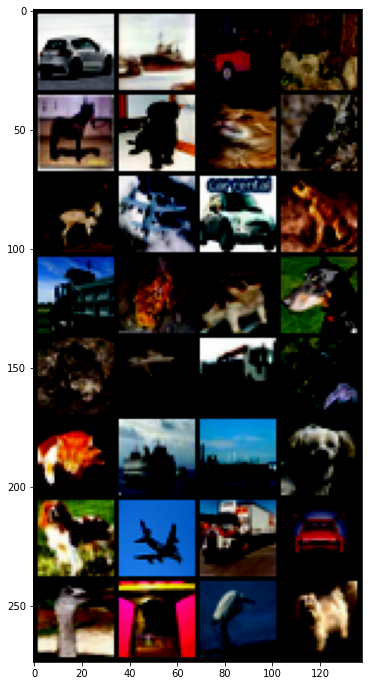

In [11]:
batch = next(iter(train_loader))
images, labels = batch
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) 

print(f"class labels: {labels}")
plt.imshow(grid.permute(1,2,0))

## 3. Define CutMix

In [17]:
def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [12]:
images.shape

torch.Size([32, 3, 32, 32])

In [15]:
rand_index = torch.randperm(images.shape[0])
shuffled_images = images[rand_index]
lam = np.random.beta(1.0, 1.0)


In [18]:
original_images = images.clone().detach() 
bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


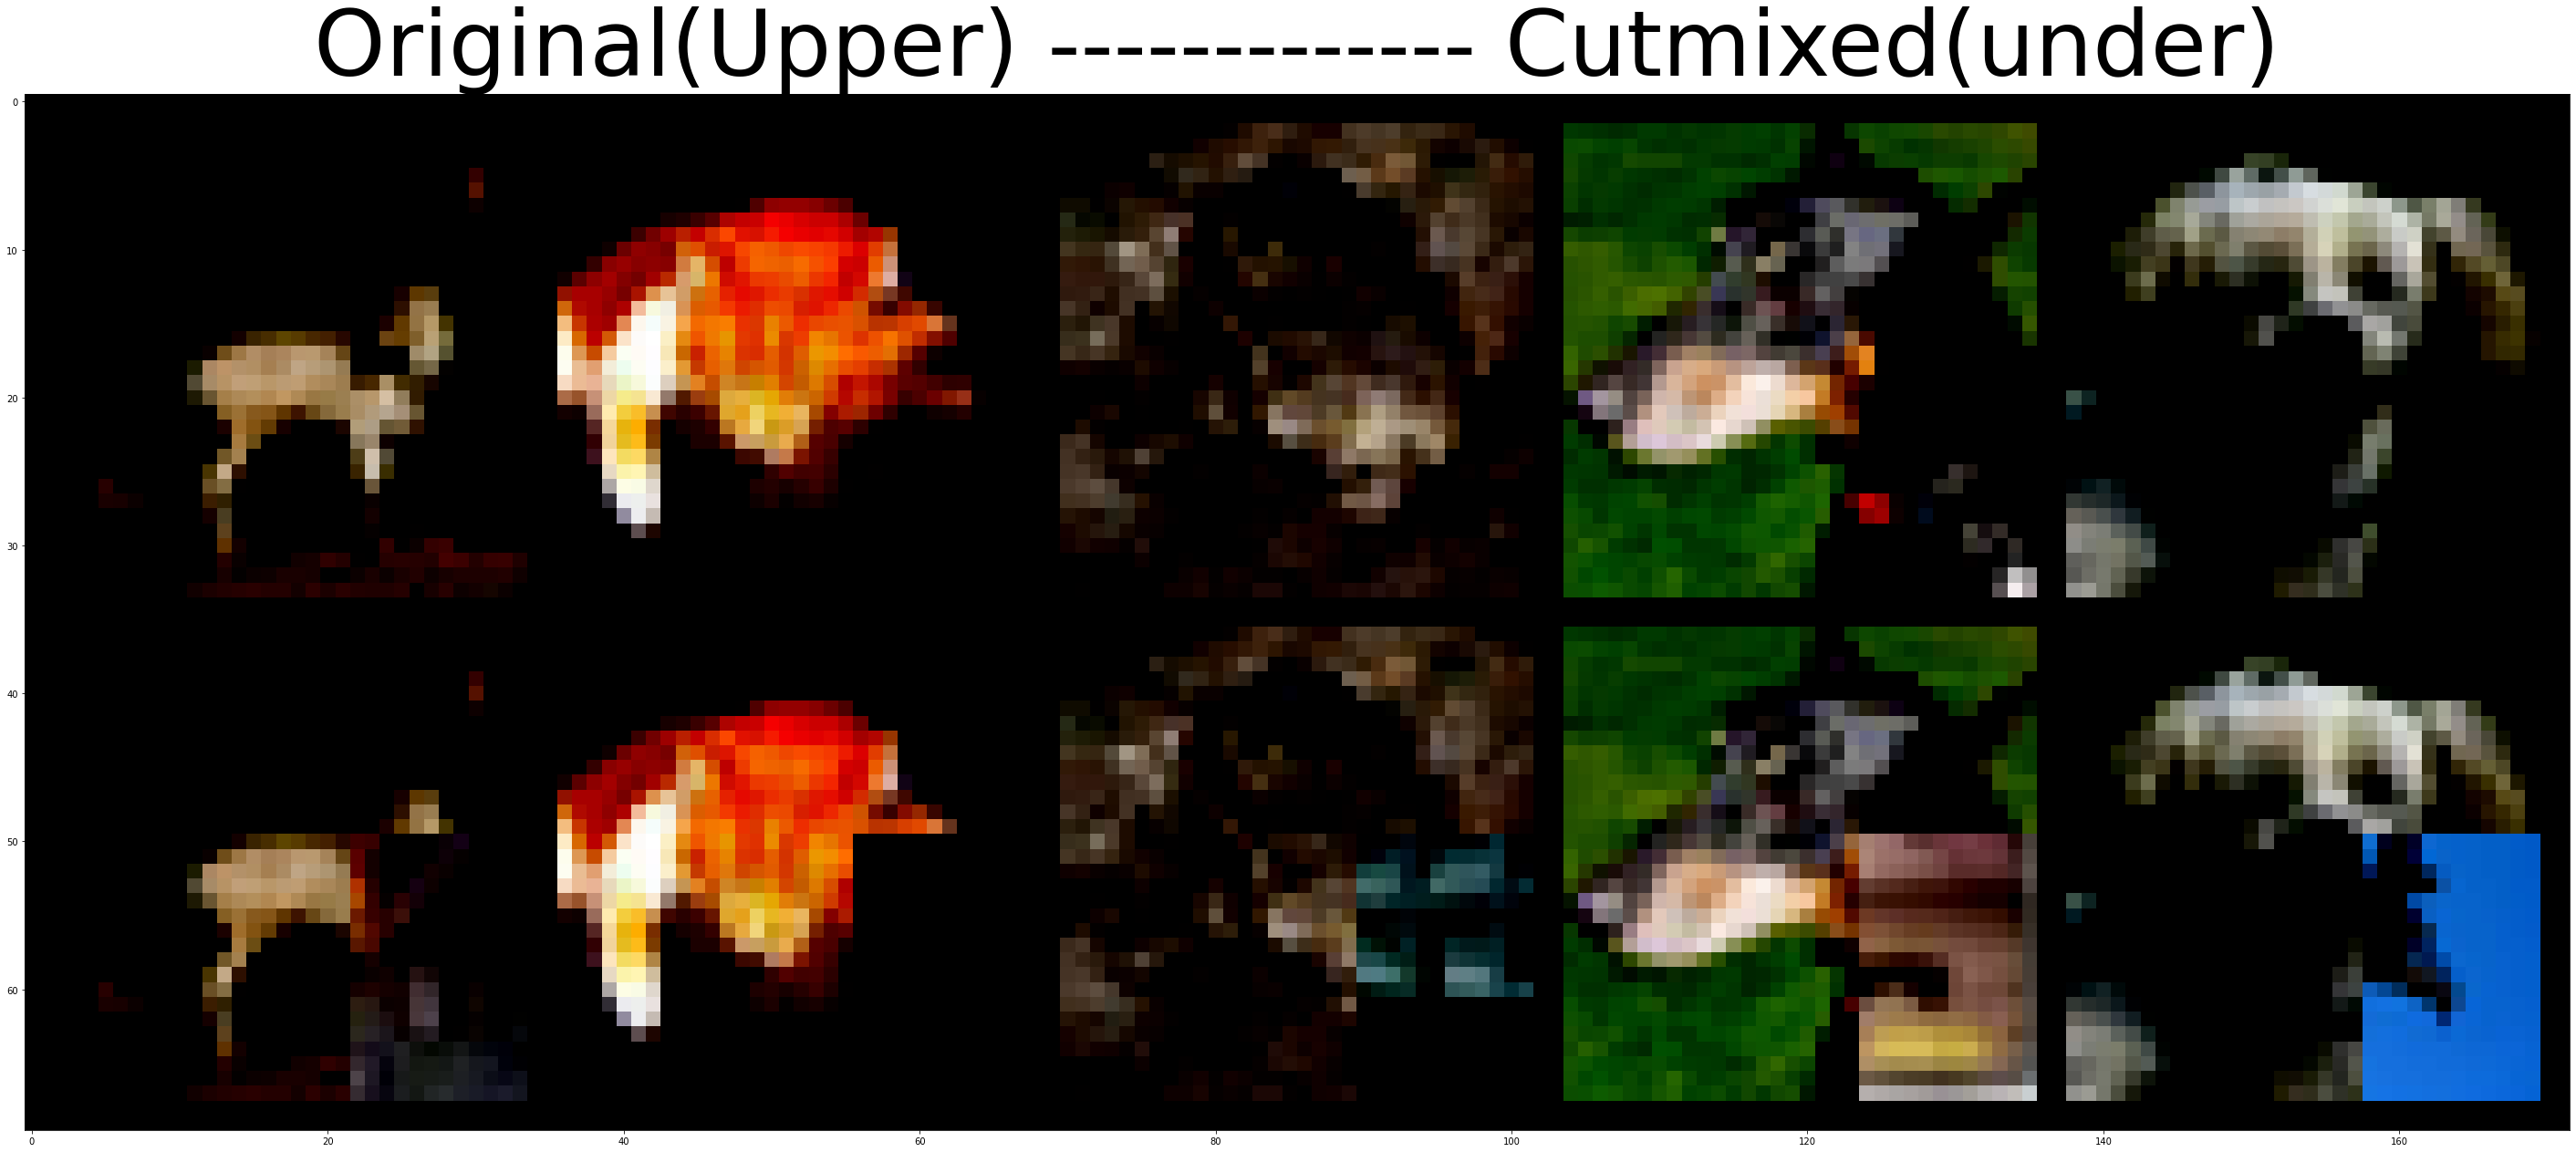

In [20]:
def show_cutMixed_compare(origin, new, nums_show):
    rand_index = torch.randperm(origin.size()[0])[:nums_show]
    to_compare = torch.cat([origin[rand_index,:,:],new[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.title("Original(Upper) ------------- Cutmixed(under)", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(original_images, images, 5)

## Make model

In [25]:
!pip install pretrainedmodels
from torch.nn import Linear
import pretrainedmodels

model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

## 우리 이미지 사이즈에 맞게 튜닝
in_features = model.last_linear.in_features
model.last_linear = torch.nn.Linear(in_features, len(classes)) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                      mode='max',
                                                      verbose=True,
                                                      patience=7,
                                                      factor=0.5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

cpu


## Start Training

In [30]:
import torch.optim as optim
from tqdm import trange

def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() # For later #
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return 100.0 * correct / total

def train_model(model, 
                train, 
                valid, 
                n_iters=500, 
                learn_rate=0.001, 
                batch_size=128, 
                weight_decay=0, 
                iscutmix=1):  # Lists to store model's performance information
  iters, losses, train_acc, val_acc = [], [], [], []

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

  for i in trange(n_iters):
    for images, labels in iter(train_loader):

      model.train() # For Dropout and Batch Norm layers #

      if iscutmix and (np.random.rand()<0.5) :
        lam = np.random.beta(1.0, 1.0)
        rand_index = torch.randperm(images.size()[0])

        shuffled_labels = labels[rand_index]
        bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
        images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2]))

        out = model(images)           # forward pass
        loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam) # compute the total loss
      else :
        out = model(images)
        loss = criterion(out, labels)

      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # reset the gradients for the next iteration

      # Save the current training and validation information at every 10th iteration
      if (i+1) % 10 == 0:
          iters.append(i)
          losses.append(float(loss)/batch_size)        # compute *average* loss
          train_acc.append(get_accuracy(model, train)) # compute training accuracy 
          val_acc.append(get_accuracy(model, valid))   # compute validation accuracy


  print(f'Plotting')
  # Plotting Training Loss, Accuracy and Validation Accuracy
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")

  plt.subplot(1,2,2)
  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
  highest=[0,0]
  for i, val_acc in zip(iters, val_acc):
    if val_acc>highest[1] :
      print(f"it achieved new high_acc at iter {i}th with {val_acc}%")
      highest = [i,val_acc]

In [31]:
train_model(model, train_loader, test_loader, n_iters=500, 
                learn_rate=0.001, batch_size=128, 
            weight_decay=0, iscutmix=1)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your 

KeyboardInterrupt: ignored